In [1]:
# Basic Packages
import os
import re
import scipy
import spacy
import itertools
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import mlflow
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification
Tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

## Initializing

In [3]:
SEED = 22
EPOCHS = 6
MAX_LEN = 500
TRAIN_SIZE = 0.75
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 16
LEARNING_RATE = 1e-05

In [4]:
def set_seed(seed):
    # Set the random seed
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(SEED)

## Reading Data

In [5]:
class NLP_Processor():
    '''
    This is a class used to prepare dataset for NLP models.
    '''
    def __init__(self, folders, categories, path):
        # self.__folders = folders
        # self.__categories = categories
        # self.__path = path
        self.source = self.get_dataframe(folders, categories, path)
        self.bert_data = self.string_cleaner(self.source.copy(), "Documents", "BERT")
        self.wv_data = self.string_cleaner(self.source.copy(), "Documents", "Word2Vec")
        
    def read_data(self, path, label, texts, labels):
        '''
        Read txt files under a specific path.
        path:   input, string
                the full path of folder where txt files are stored
        label:  input, string
                the label for txt files under path
        texts:  input, list
                a list to store all imported strings
        labels: input, list
                a list to store the labels for each string
        '''
        files = os.listdir(path)
        for file in files:
            labels.append(label)
            full_path = os.path.join(path,file)
            with open(full_path, encoding='gb18030', errors='ignore') as file_obj:
                content = file_obj.read()
                texts.append(content) 
                
    def get_dataframe(self, folders, categories, path):
        '''
        This is a function used to get data from different folders with diffrent categories.
        All the folders are stored under one path.
        The output of this function is a dataframe that contains all strings.
        folders:    input, list
                    the list of folders
        categoreis: input, list
                    the list of categories corresponding to each folder
        path:       the full path where the folders are stored
        '''
        texts = list()
        labels = list()
        for i in range(0, len(folders)):
            folder_path = path + '/' + folders[i]
            label = categories[i]
            self.read_data(folder_path, label, texts, labels)
        doc_dict = {"Documents":texts, "Categories":labels}
        df = pd.DataFrame(doc_dict, columns=["Documents", "Categories"])
        return df   
    
    def string_cleaner(self, df, col, mod):
        '''
        Clean the strings.
        df:     input, pdd.DataFrame
                where the strings are stored
        col:    input, string
                indicate which column is required cleaning
        mod:    input, string
                Prepare dataset for different vectorizing method: Bert, Word2Vec.etc
        '''
        df[col]=df[col].apply(lambda x:x.replace("\n"," "))
        df[col]=df[col].apply(lambda x:re.sub("[^A-Za-z0-9(),.!?\'\`]", " ", x))
        if mod != 'BERT':  
            df[col]=df[col].apply(lambda x:re.sub("\'s", " ", x))
            df[col]=df[col].apply(lambda x:re.sub("\'ve", " have ", x))
            df[col]=df[col].apply(lambda x:re.sub("n\'t", " not ", x))
            df[col]=df[col].apply(lambda x:re.sub(r"\'re", " are ", x))
            df[col]=df[col].apply(lambda x:re.sub(r"\'d", " would ", x))
            df[col]=df[col].apply(lambda x:re.sub(r"\'ll", " will ", x))
            df[col]=df[col].apply(lambda x:re.sub(r",", " , ", x))
            df[col]=df[col].apply(lambda x:re.sub(r"\.", " . ", x))
            df[col]=df[col].apply(lambda x:re.sub(r"!", " ! ", x))
            df[col]=df[col].apply(lambda x:re.sub(r"\?", " ? ", x)) 
            df[col]=df[col].apply(lambda x:re.sub(r"\(", " ( ", x))
            df[col]=df[col].apply(lambda x:re.sub(r"\)", " ) ", x))
        df[col]=df[col].apply(lambda x:re.sub(r"\s{2,}", " ", x))
        return df

In [6]:
# Read data and get the dataset prepared
folders = ['business', 'entertainment', 'politics', 'sport', 'tech']
categories = ['Business', 'Entertainment', 'Politics', 'Sport', 'Technology']
path = '~/NLP Research'

processor = NLP_Processor(folders, categories, path)

In [7]:
def data_split(train_size, df, seed):
    '''
    Split dataset into training and testing samples.
    train_size:     input, float
                    the size of training set (a portion)
    df:             input, pd.DataFrame
                    all data samples
    seed:           input, int
                    random seed
    '''
    train_df = df.sample(frac=train_size, random_state=seed)
    test_df = df.drop(train_df.index).reset_index(drop=True)
    train_df = train_df.reset_index(drop=True)
    return train_df, test_df

In [8]:
bert_data = processor.bert_data
train_df, test_df = data_split(TRAIN_SIZE, bert_data, SEED)

print("FULL Dataset: {}".format(bert_data.shape))
print("TRAIN Dataset: {}".format(train_df.shape))
print("TEST Dataset: {}".format(test_df.shape))

FULL Dataset: (2225, 2)
TRAIN Dataset: (1669, 2)
TEST Dataset: (556, 2)


In [9]:
def binary_creator(category, df, col):
    '''
    Create balance binary dataset, 1 for selected category, 0 for other cats.
    category:   input, string
                the label of a specific topic
    df:         input, pd.DataFrame
    col:        input, string
                the name of column where labels are stored
    '''
    df_1 = df.copy()
    cat_1 = df_1[df_1[col] == category]
    df_1 = df_1.drop(cat_1.index).reset_index(drop=True)    
    
    # preparation for oversampling if sample <500
    cat_2 = df_1.sample(n=len(cat_1),random_state=22)        
    df_set = pd.concat([cat_1, cat_2])
    # df_set.reset_index(inplace=True, drop=True)
    df_set[col][df_set[col] != category]=0
    df_set[col][df_set[col] == category]=1
    df_set = df_set.sample(frac=1).reset_index(drop=True)
    
    return df_set

In [10]:
def target_encoder(df, col, categories):
    '''
    Transform string label.
    df:         input, pd.DataFrame
    col:        input, string
                the name of column where labels are stored
    categories: input, the list of categories
    '''
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    le.fit(categories)
    df[col]=le.transform(df[col])
    return df

In [11]:
busi_train = binary_creator('Business', train_df, 'Categories')
print("Business Train Dataset: {}".format(busi_train.shape))

ent_train = binary_creator('Entertainment', train_df, 'Categories')
print("Entertainment Train Dataset: {}".format(ent_train.shape))

pol_train = binary_creator('Politics', train_df, 'Categories')
print("Policy Train Dataset: {}".format(pol_train.shape))

sp_train = binary_creator('Sport', train_df, 'Categories')
print("Sports Train Dataset: {}".format(sp_train.shape))

tech_train = binary_creator('Technology', train_df, 'Categories')
print("Technology Train Dataset: {}".format(tech_train.shape))

Business Train Dataset: (778, 2)
Entertainment Train Dataset: (582, 2)
Policy Train Dataset: (590, 2)
Sports Train Dataset: (770, 2)
Technology Train Dataset: (618, 2)


In [12]:
busi_test = binary_creator('Business', test_df, 'Categories')
print("Business Test Dataset: {}".format(busi_test.shape))

ent_test = binary_creator('Entertainment', test_df, 'Categories')
print("Entertainment Test Dataset: {}".format(ent_test.shape))

pol_test = binary_creator('Politics', test_df, 'Categories')
print("Policy Test Dataset: {}".format(pol_test.shape))

sp_test = binary_creator('Sport', test_df, 'Categories')
print("Sports Test Dataset: {}".format(sp_test.shape))

tech_test = binary_creator('Technology', test_df, 'Categories')
print("Technology Test Dataset: {}".format(tech_test.shape))

Business Test Dataset: (242, 2)
Entertainment Test Dataset: (190, 2)
Policy Test Dataset: (244, 2)
Sports Test Dataset: (252, 2)
Technology Test Dataset: (184, 2)


## Prepare for training

In [13]:
# Create a CustomDataset class to prepare data for Pytorch
class CustomDataset(Dataset):
    '''
    Inherit Dataset class from torch and re-write its methods.
    '''
    # def __init__(self, dataframe, text, target, tokenizer, max_len):
    def __init__(self, dataframe, text, target, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe[text]
        self.targets = dataframe[target]
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index): 
        '''
        Transform a text string into the form as the input of BERT pre-trained model.
        '''
        comment_text = str(self.comment_text[index]) #certain sentence
        comment_text = " ".join(comment_text.split()) #split and then join
        # What are the outputs of tokenizer.encode_plus()
        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=False,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

In [14]:
# source is the return of getitem
# https://pytorch.org/docs/master/generated/torch.nn.utils.rnn.pad_sequence.html
def pad_seq(seq, max_batch_len, pad_value):
    '''
    Pad inputs for BERT pre-trained model.
    seq:           input, 
                   the seq that needed padding
    max_batch_len: input, int
                   the max lenth to pad
    pad_value:     input,
                   the value used to pad
    '''
    # IRL, use pad_sequence
    return seq + (max_batch_len - len(seq)) * [pad_value]

# Create batches 
def collate_batch(batch, tokenizer):
    '''
    Build batches for Pytorch.
    tokenizer: input,
               the tokenizer used to tokenize texts
    '''
    batch_inputs = list()
    batch_attention_masks = list()
    batch_token_type_ids=list()
    labels = list()
    # find the max length of the mini batch
    max_size = max([len(ex['ids']) for ex in batch])
    for item in batch:
        # apply padding at the mini batch level
        batch_inputs += [pad_seq(item['ids'].tolist(), max_size, tokenizer.pad_token_id)]
        batch_attention_masks += [pad_seq(item['mask'].tolist(), max_size, 0)]
        batch_token_type_ids += [pad_seq(item['token_type_ids'].tolist(), max_size, 0)]
        labels.append(item['targets'].tolist())
    # expected Transformers input format (dict of Tensors)
    return {"ids": torch.tensor(batch_inputs, dtype=torch.long),
            "mask": torch.tensor(batch_attention_masks, dtype=torch.long),
            "token_type_ids": torch.tensor(batch_token_type_ids, dtype=torch.long),
            "targets": torch.tensor(labels, dtype=torch.long)
            }

In [15]:
Train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

Test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

In [16]:
class BERTClass(torch.nn.Module):
    '''
    Creating the customized model, by adding a dropout and a dense layer on top of distil bert 
    to get the final output for the model. 
    '''
    def __init__(self):
        super(BERTClass, self).__init__()
        # ,return_dict=False
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased',return_dict=False)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 1)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

In [17]:
class BERT_Binary_Classifier():
    '''
    Pack all components up. Including the datast, optimizer, loss function and the 
    training/validation functions.
    '''
    def __init__(self, train_set, test_set, tokenizer, device):
        self.train_set = train_set
        self.test_set = test_set
        self.tokenizer = tokenizer
        self.device = device
        self.model = BERTClass()
        self.model.to(device) 
    
    def set_optimizer(self, learning_rate):
        self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=learning_rate)
        
    def loss_fn(self, outputs, targets):
        return torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([1.7]))(outputs.flatten(), targets.type_as(outputs))
        
    def set_dataset(self, text, target, max_len):
        self.training_set = CustomDataset(self.train_set, text, target, self.tokenizer, max_len)
        self.testing_set = CustomDataset(self.test_set, text, target, self.tokenizer, max_len)
        
    def set_dataloader(self, func, train_params, test_params):
        self.training_loader = DataLoader(self.training_set, collate_fn=lambda batch: func(batch, self.tokenizer), **train_params)
        self.testing_loader = DataLoader(self.testing_set, collate_fn=lambda batch: func(batch, self.tokenizer), **test_params)
        
    def train(self):
        '''
        The function to train a Pytorch-based NN.
        '''
        self.model.train()
        for _,data in enumerate(self.training_loader, 0):
            ids = data['ids'].to(self.device, dtype=torch.long)
            mask = data['mask'].to(self.device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(self.device, dtype=torch.long)
            targets = data['targets'].to(self.device, dtype=torch.long)

            outputs = self.model(ids, mask, token_type_ids)
            # remove cache of gradient
            self.optimizer.zero_grad() 
            loss = self.loss_fn(outputs, targets) 
            # print(f'epoch: {epoch}, Loss:  {loss.item()}, {_}')
            loss.backward()
            self.optimizer.step()
        print("Model Training Finished!")   
        
    def validation(self, data_loader):
        '''
        The function to validate a Pytorch-based NN model.
        '''
        self.model.eval()
        fin_targets=[]
        fin_outputs=[]
        with torch.no_grad():
            for cnt, data in enumerate(data_loader, 0):
                ids = data['ids'].to(self.device, dtype=torch.long)
                mask = data['mask'].to(self.device, dtype=torch.long)
                token_type_ids = data['token_type_ids'].to(self.device, dtype=torch.long)
                targets = data['targets'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask, token_type_ids)
                fin_targets.extend(targets.cpu().detach().numpy().tolist())
                fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
        fin_outputs = [pred[0] for pred in fin_outputs]
        # loss = loss_fn(fin_outputs, fin_targets) 
        return fin_outputs, fin_targets 
    
    def epoch_train(self, epochs, filename):
        '''
        The function to get the early stopping time point.
        '''
        from sklearn.metrics import log_loss
        train_losses = list()
        test_losses = list()
        for epoch in range(epochs):
            self.train()
            train_outputs, train_targets = self.validation(self.training_loader)
            train_loss = log_loss(train_targets, train_outputs) 
            
            test_outputs, test_targets = self.validation(self.testing_loader)
            test_loss = log_loss(test_targets, test_outputs) 

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            if epoch == 4:
                torch.save(self.model, '/home/hzhan10/NLP Research/' + filename + '.pt')
            
            print(str(epoch) + ' epoch finished!')
        return train_losses, test_losses

## Model Training for each document category

In [18]:
# Training the binary classifier for Business topic documents
busi_classifier = BERT_Binary_Classifier(busi_train, busi_test, Tokenizer, 'cpu')
busi_classifier.set_optimizer(LEARNING_RATE)
busi_classifier.set_dataset("Documents", "Categories", MAX_LEN)
busi_classifier.set_dataloader(collate_batch, Train_params, Test_params)
busi_train_losses, busi_test_losses = busi_classifier.epoch_train(EPOCHS, 'Busi_BERT')

Model Training Finished!
0 epoch finished!
Model Training Finished!
1 epoch finished!
Model Training Finished!
2 epoch finished!
Model Training Finished!
3 epoch finished!
Model Training Finished!
4 epoch finished!
Model Training Finished!
5 epoch finished!


In [19]:
# Training the binary classifier for Entertainment topic documents
ent_classifier = BERT_Binary_Classifier(ent_train, ent_test, Tokenizer, 'cpu')
ent_classifier.set_optimizer(LEARNING_RATE)
ent_classifier.set_dataset("Documents", "Categories", MAX_LEN)
ent_classifier.set_dataloader(collate_batch, Train_params, Test_params)
ent_train_losses, ent_test_losses = ent_classifier.epoch_train(EPOCHS, 'Ent_BERT')

Model Training Finished!
0 epoch finished!
Model Training Finished!
1 epoch finished!
Model Training Finished!
2 epoch finished!
Model Training Finished!
3 epoch finished!
Model Training Finished!
4 epoch finished!
Model Training Finished!
5 epoch finished!


In [20]:
# Training the binary classifier for Politics topic documents
pol_classifier = BERT_Binary_Classifier(pol_train, pol_test, Tokenizer, 'cpu')
pol_classifier.set_optimizer(LEARNING_RATE)
pol_classifier.set_dataset("Documents", "Categories", MAX_LEN)
pol_classifier.set_dataloader(collate_batch, Train_params, Test_params)
pol_train_losses, pol_test_losses = pol_classifier.epoch_train(EPOCHS, 'Pol_BERT')

Model Training Finished!
0 epoch finished!
Model Training Finished!
1 epoch finished!
Model Training Finished!
2 epoch finished!
Model Training Finished!
3 epoch finished!
Model Training Finished!
4 epoch finished!
Model Training Finished!
5 epoch finished!


In [21]:
# Training the binary classifier for Sport topic documents
sp_classifier = BERT_Binary_Classifier(sp_train, sp_test, Tokenizer, 'cpu')
sp_classifier.set_optimizer(LEARNING_RATE)
sp_classifier.set_dataset("Documents", "Categories", MAX_LEN)
sp_classifier.set_dataloader(collate_batch, Train_params, Test_params)
sp_train_losses, sp_test_losses = sp_classifier.epoch_train(EPOCHS, 'Sp_BERT')

Model Training Finished!
0 epoch finished!
Model Training Finished!
1 epoch finished!
Model Training Finished!
2 epoch finished!
Model Training Finished!
3 epoch finished!
Model Training Finished!
4 epoch finished!
Model Training Finished!
5 epoch finished!


In [22]:
# Training the binary classifier for Technology topic documents
tech_classifier = BERT_Binary_Classifier(tech_train, tech_test, Tokenizer, 'cpu')
tech_classifier.set_optimizer(LEARNING_RATE)
tech_classifier.set_dataset("Documents", "Categories", MAX_LEN)
tech_classifier.set_dataloader(collate_batch, Train_params, Test_params)
tech_train_losses, tech_test_losses = tech_classifier.epoch_train(EPOCHS, 'Tech_BERT')

Model Training Finished!
0 epoch finished!
Model Training Finished!
1 epoch finished!
Model Training Finished!
2 epoch finished!
Model Training Finished!
3 epoch finished!
Model Training Finished!
4 epoch finished!
Model Training Finished!
5 epoch finished!


## Model Validation

In [23]:
# Create a CustomDataset class to prepare data for Pytorch
class TestDataset(Dataset):
    '''
    Inherit Dataset class from torch and re-write its methods.
    Prepare the testing dataset.
    '''
    def __init__(self, dataframe, text, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe[text]
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index): 
        comment_text = str(self.comment_text[index]) #certain sentence
        comment_text = " ".join(comment_text.split()) #split and then join
        # What are the outputs of tokenizer.encode_plus()
        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=False,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
        }

In [24]:
# Create batches 
def collate_test(batch, tokenizer):
    '''
    Build batches for testing samples.
    tokenizer: input, 
               the tokenizer used to tokenize texts
    '''
    batch_inputs = list()
    batch_attention_masks = list()
    batch_token_type_ids=list()
    labels = list()
    # find the max length of the mini batch
    max_size = max([len(ex['ids']) for ex in batch])
    for item in batch:
        # apply padding at the mini batch level
        batch_inputs += [pad_seq(item['ids'].tolist(), max_size, tokenizer.pad_token_id)]
        batch_attention_masks += [pad_seq(item['mask'].tolist(), max_size, 0)]
        batch_token_type_ids += [pad_seq(item['token_type_ids'].tolist(), max_size, 0)]
    # expected Transformers input format (dict of Tensors)
    return {"ids": torch.tensor(batch_inputs, dtype=torch.long),
            "mask": torch.tensor(batch_attention_masks, dtype=torch.long),
            "token_type_ids": torch.tensor(batch_token_type_ids, dtype=torch.long),
            }

In [25]:
def model_validation(device, model, data_loader):
    '''
    Validate models on the testing set of a specific topic.
    device:      input, string
                 the device used to validate the model
    model:       input, BERTClass
                 the model that needs validation
    data_loader: input, torch.DataLoader
    '''
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for cnt, data in enumerate(data_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    fin_outputs = [pred[0] for pred in fin_outputs]
    return fin_outputs, fin_targets 

def model_inference(device, model, data_loader):
    '''
    Validate models on a testing set consisting of samples from all topics.
    device:      input, string
                 the device used to make inference
    model:       input, BERTClass
                 the model that making inference with
    data_loader: input, torch.DataLoader
    '''
    model.eval()
    fin_outputs=[]
    with torch.no_grad():
        for cnt, data in enumerate(data_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    fin_outputs = [pred[0] for pred in fin_outputs] 
    return fin_outputs

In [26]:
# Prepare the testing set(containg samples from all categories)
testing_set = TestDataset(test_df, "Documents", Tokenizer, MAX_LEN)
testing_loader = DataLoader(testing_set, collate_fn=lambda batch: collate_test(batch, Tokenizer), **Test_params)

In [27]:
busi_model = torch.load('~/NLP Research/Busi_BERT.pt')
busi_test_outputs, busi_test_targets = model_validation('cpu', busi_model, busi_classifier.testing_loader)
busi_outputs = model_inference('cpu', busi_model, testing_loader)

In [28]:
ent_model = torch.load('~/NLP Research/Ent_BERT.pt')
ent_test_outputs, ent_test_targets = model_validation('cpu', ent_model, ent_classifier.testing_loader)
ent_outputs = model_inference('cpu', ent_model, testing_loader)

In [29]:
pol_model = torch.load('~/NLP Research/Pol_BERT.pt')
pol_test_outputs, pol_test_targets = model_validation('cpu', pol_model, pol_classifier.testing_loader)
pol_outputs = model_inference('cpu', pol_model, testing_loader)

In [30]:
sp_model = torch.load('~/NLP Research/Sp_BERT.pt')
sp_test_outputs, sp_test_targets = model_validation('cpu', sp_model, sp_classifier.testing_loader)
sp_outputs = model_inference('cpu', sp_model, testing_loader)

In [31]:
tech_model = torch.load('~/NLP Research/Tech_BERT.pt')
tech_test_outputs, tech_test_targets = model_validation('cpu', tech_model, tech_classifier.testing_loader)
tech_outputs = model_inference('cpu', tech_model, testing_loader)

In [32]:
def plot_precision_recall_threshold(labels, scores, y_range, title, x_range=None):
    '''
    Plot the precision and recall rates by thresholds.
    labels:     input, list
                list of 0-1 labels
    scores:     input, list
                scores given by a classifier
    y_range:    input, 
                the range of y-axis
    title:      input, string
                the title of this picture
    '''
    # import matplotlib.pyplot as plt
    from sklearn.metrics import precision_recall_curve
    # plt.figure(figsize=(8,4))
    precisions, recalls, thresholds = precision_recall_curve(labels, scores)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "r-", label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Rate")
    plt.legend(loc="lower left", facecolor="#FFFFFF")
    ax = plt.gca()
    ax.set_facecolor('#FFFFFF')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    plt.title(title)
    plt.ylim(y_range)
    if x_range:
        plt.xlim(x_range)
        
def plot_loss(x, train_loss, vali_loss, axis_range, title=None):
    '''
    Plot losses on validation and training set.
    x:          input, 
                range of x-axis
    train_loss: input, list
                the losses on training set
    vali_loss:  input, list
                the losses on testing set
    axis_range: input,
                the range of x-axis and y-axis
    '''
    # import matplotlib.pyplot as plt
    # plt.figure()
    plt.plot(x, train_loss, label='Training')
    plt.plot(x, vali_loss, label='Validation')
    plt.axis(axis_range)
    plt.xlabel('EPOCHs')
    plt.ylabel('Loss')
    plt.legend(facecolor="#FFFFFF")
    plt.grid(False)
    plt.title(title)
    ax = plt.gca()
    ax.set_facecolor('#FFFFFF')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    plt.axis('on')

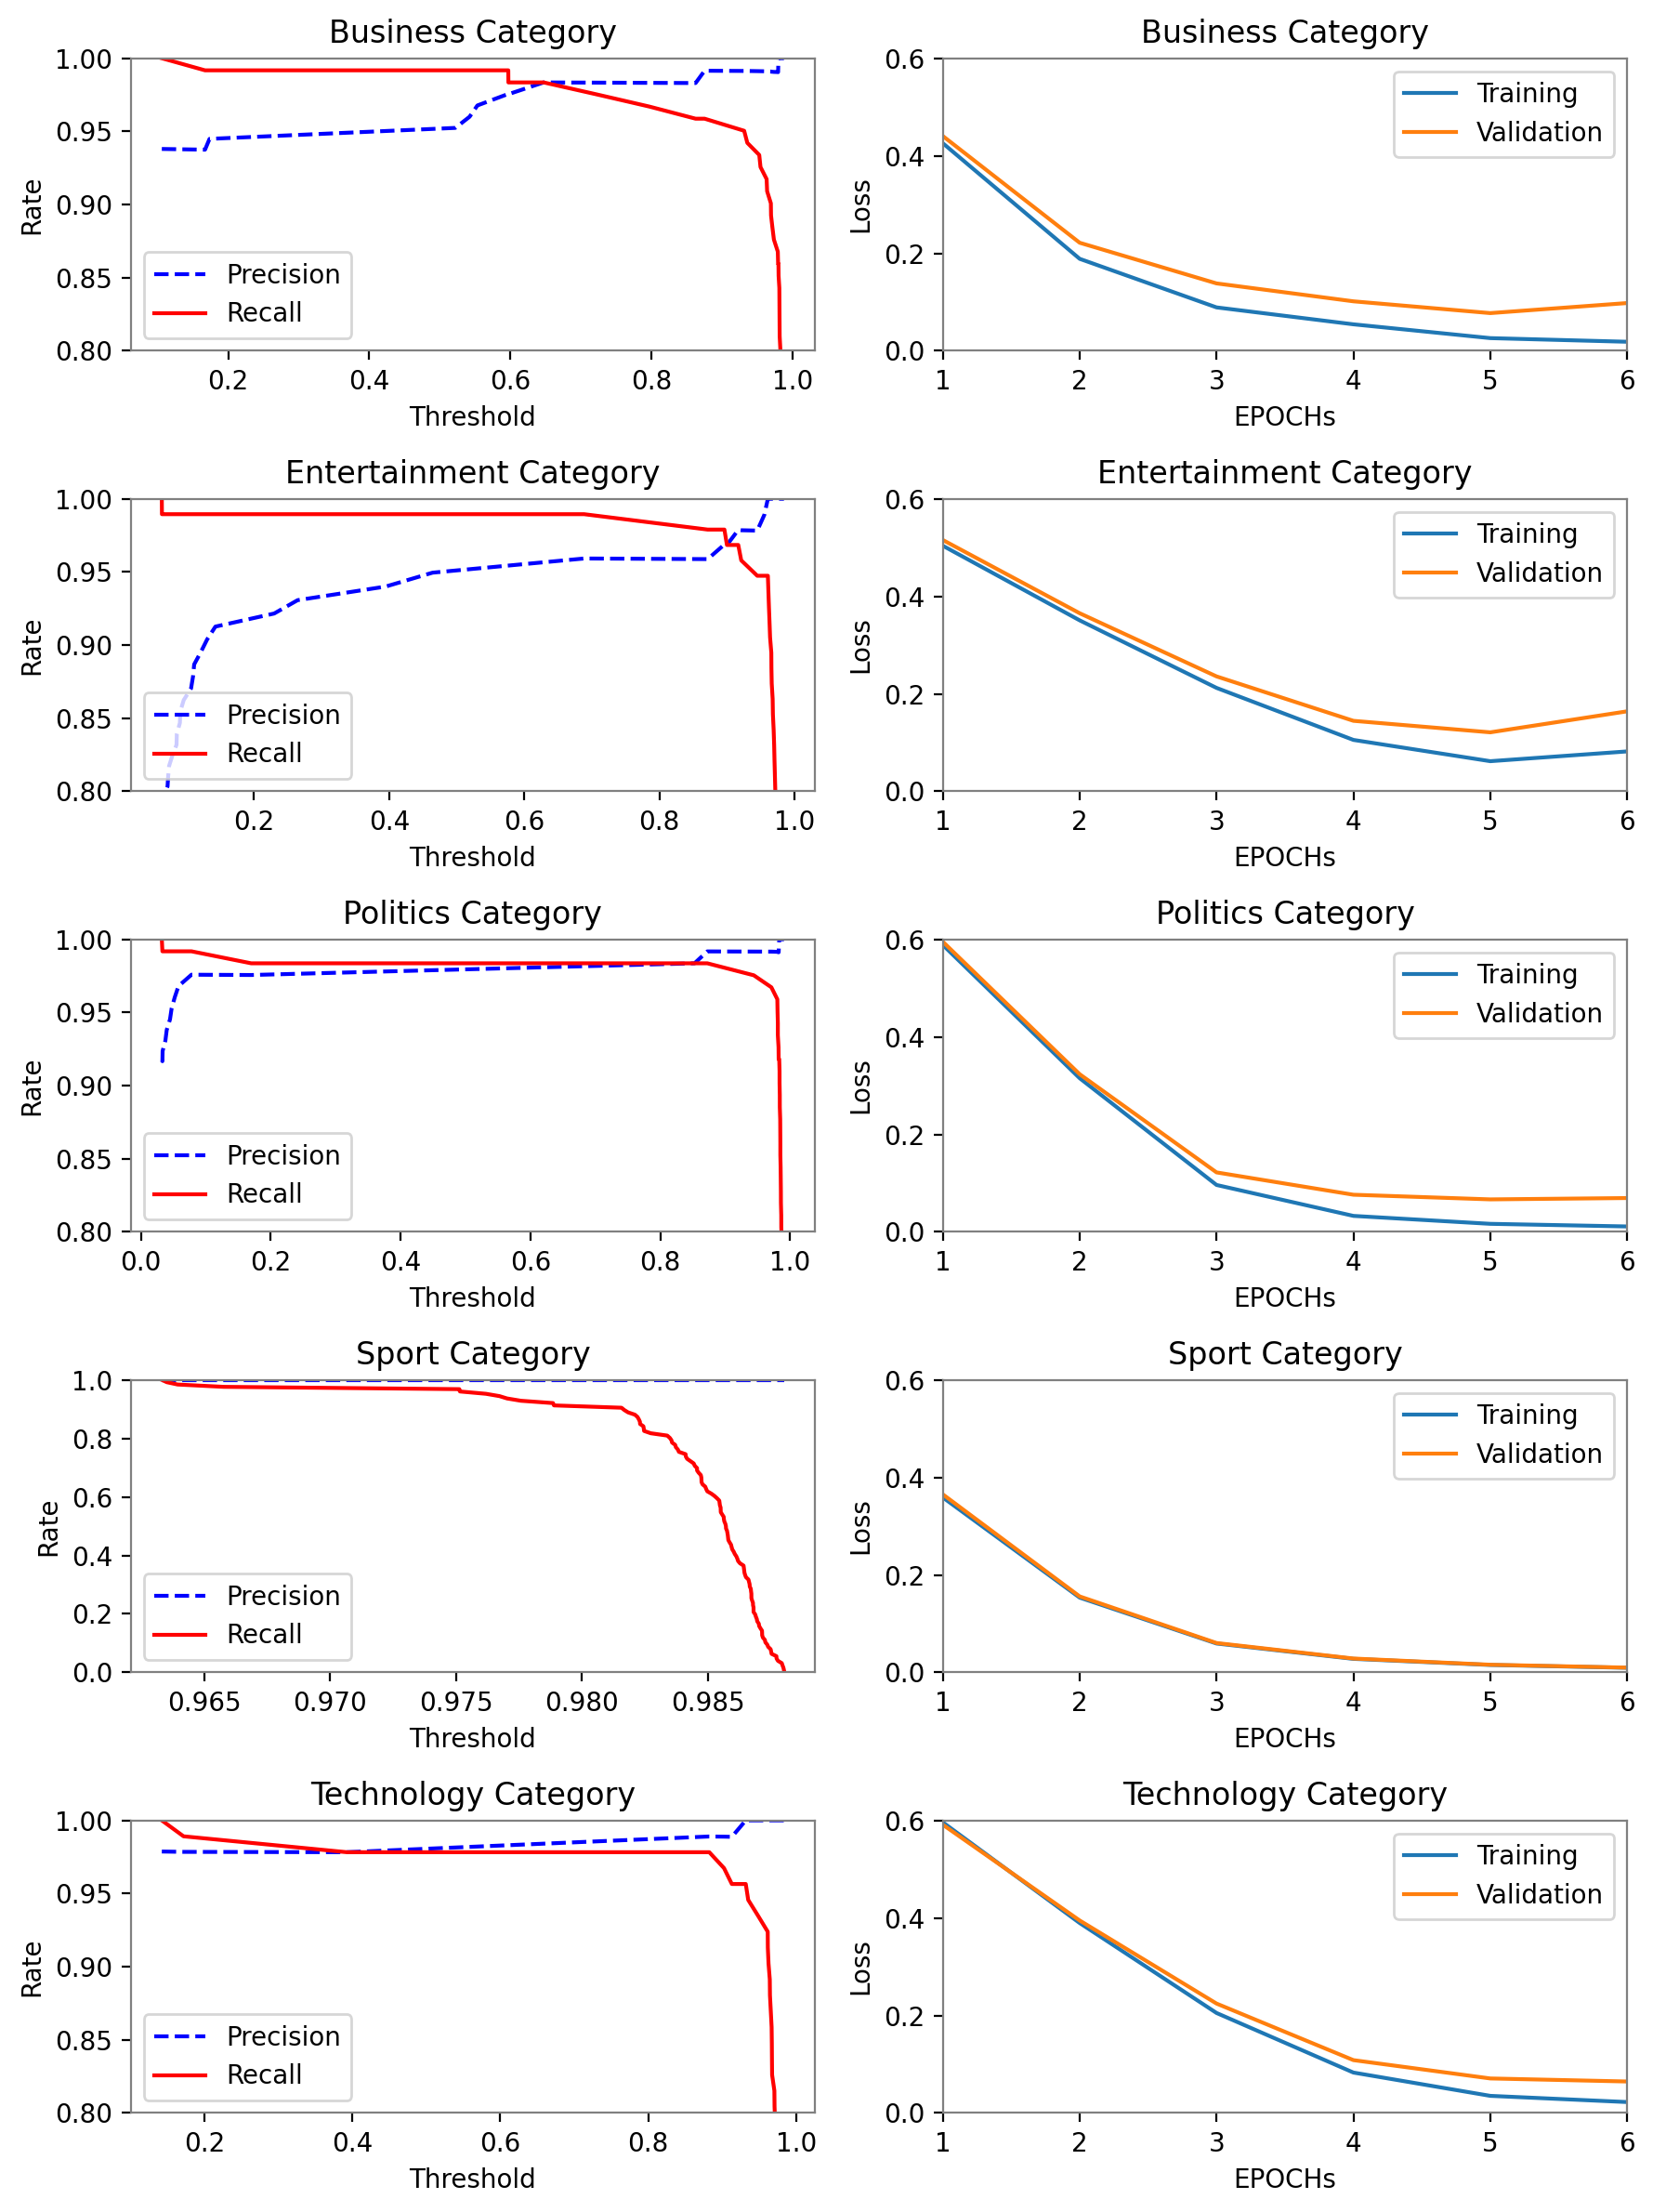

In [33]:
import matplotlib.pyplot as plt
x = range(1,7)
plt.figure(figsize=(9,12), dpi=200)
plt.subplot(5,2,1)
plot_precision_recall_threshold(busi_test_targets, busi_test_outputs, [0.8,1], "Business Category")
plt.subplot(5,2,2)
plot_loss(x, busi_train_losses, busi_test_losses, [1, 6, 0, 0.6], title="Business Category")
# plt.figure(figsize=(10,20), dpi=200)
plt.subplot(5,2,3)
plot_precision_recall_threshold(ent_test_targets, ent_test_outputs, [0.8,1], "Entertainment Category")
plt.subplot(5,2,4)
plot_loss(x, ent_train_losses, ent_test_losses, [1, 6, 0, 0.6], title="Entertainment Category")
plt.subplot(5,2,5)
plot_precision_recall_threshold(pol_test_targets, pol_test_outputs, [0.8,1], "Politics Category")
plt.subplot(5,2,6)
plot_loss(x, pol_train_losses, pol_test_losses, [1, 6, 0, 0.6], title="Politics Category")
plt.subplot(5,2,7)
plot_precision_recall_threshold(sp_test_targets, sp_test_outputs, [0,1], "Sport Category")
plt.subplot(5,2,8)
plot_loss(x, sp_train_losses, sp_test_losses, [1, 6, 0, 0.6], title="Sport Category")
plt.subplot(5,2,9)
plot_precision_recall_threshold(tech_test_targets, tech_test_outputs, [0.8,1], "Technology Category")
plt.subplot(5,2,10)
plot_loss(x, tech_train_losses, tech_test_losses, [1, 6, 0, 0.6], title="Technology Category")
plt.tight_layout()
plt.savefig('Binary Claasifier Performance.png')

In [34]:
def one_vs_rest_predict(categories, pred_list):
    '''
    Transfrom binary classification results into muti-class results.
    categories:     input, list
                    the list of categoreis
    pred_list:      input, list
                    the list of predicted results from each binary classifier
    The order of components from categories and pred_list should be matched.
    '''
    pred_dict = dict()
    for i in range(len(categories)):
        pred_dict[categories[i]] = pred_list[i]
    pred_df = pd.DataFrame(pred_dict)
    pred_labels = list()
    for j in range(pred_df.shape[0]):
        pos = np.argmax(list(pred_df.loc[j,:]))
        pred_labels.append(categories[pos])
    return pred_labels

In [35]:
# cates = ["Business", "Entertainment", "Politics", "Sport", "Technology"]
preds = [busi_outputs, ent_outputs, pol_outputs, sp_outputs, tech_outputs]
pred_labels = one_vs_rest_predict(categories, preds)

In [36]:
def draw_confusion_matrix(trues, preds, labels, norm, figure_size=(8,6), file_name='One VS Rest Classifier Heatmap.png'):
    '''
    Draw the confusion matrix for a multi-class classifier.
    trues:  input, list
            the grand truth
    preds:  input, list
            the predicted values
    labels: input, list
            the labels of confusion matrix
    norm:   input, 
            scale the values of matrix to (0,1) or not
    '''    
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    plt.figure(figsize=(9,6), dpi=200)
    mat = confusion_matrix(trues, preds, labels=labels, normalize=norm)
    sns.set(rc={'figure.figsize':figure_size})
    s=sns.heatmap(mat, annot=True, xticklabels=labels, yticklabels=labels, fmt='g')
    plt.savefig(file_name)
    plt.yticks(rotation=0) 
    s.set(xlabel='Predicted Labels', ylabel='True Labels')
    plt.show()

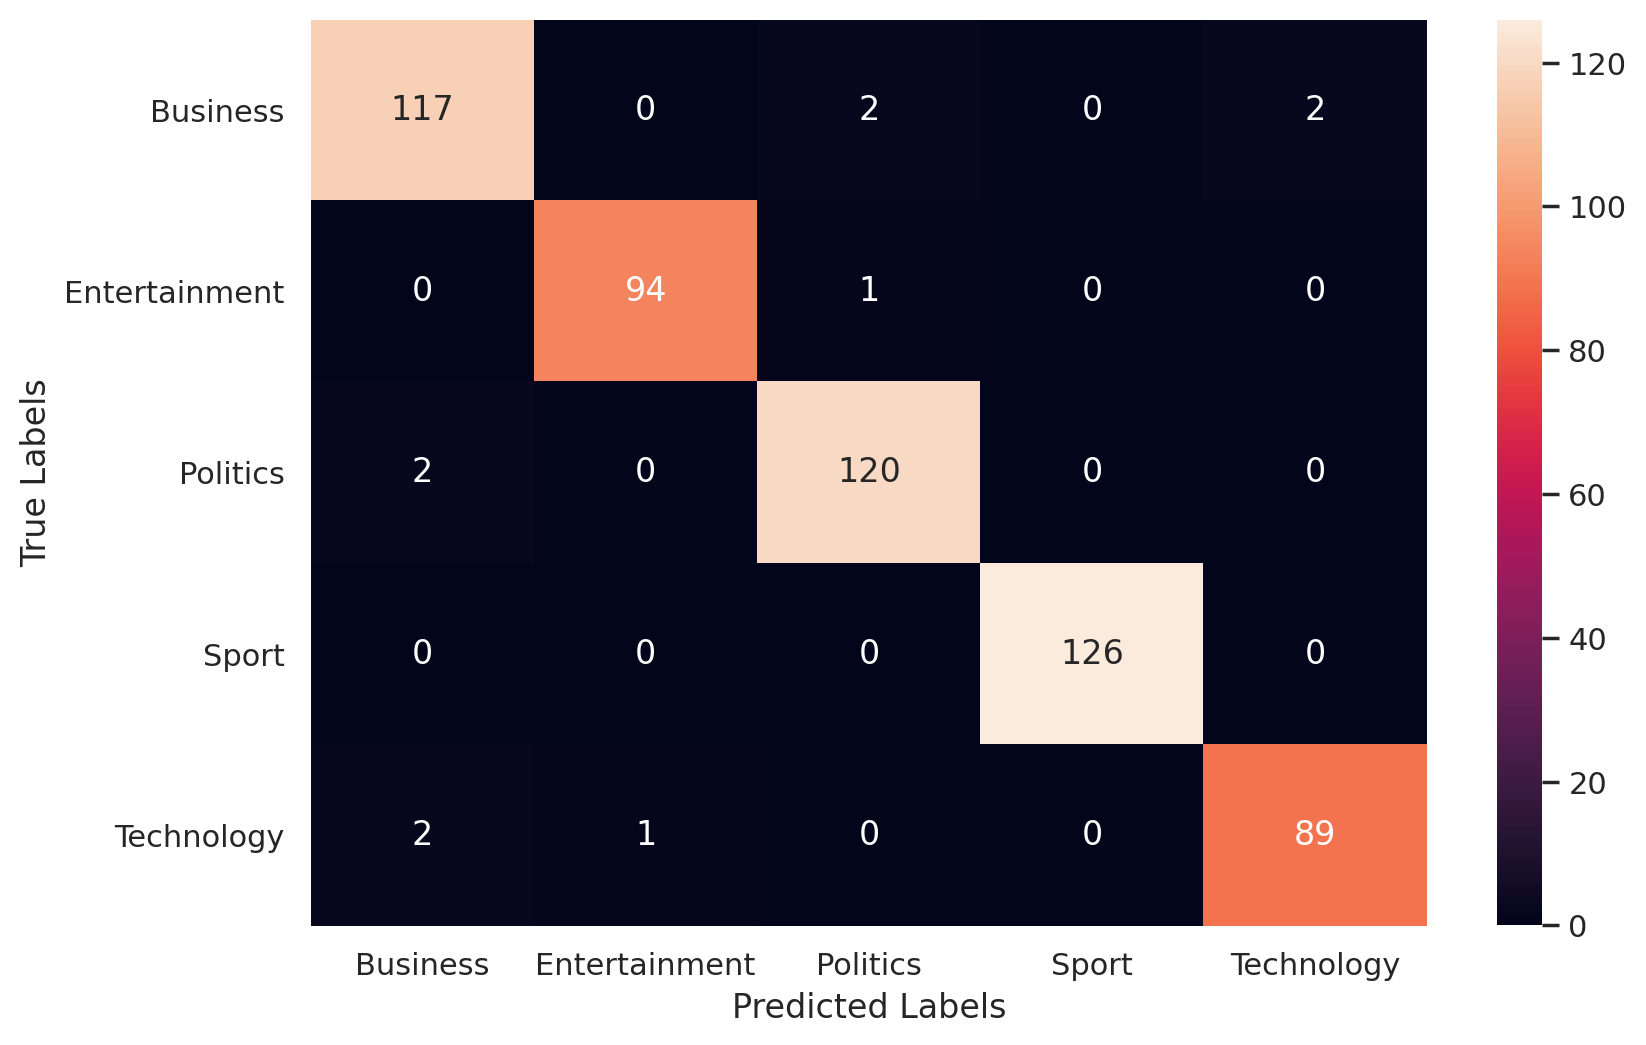

In [37]:
draw_confusion_matrix(list(test_df["Categories"]), pred_labels, labels=categories, norm=None)